In [1]:
# importing libs

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.offline as py
import seaborn as sns

py.init_notebook_mode(connected=True)
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import warnings

warnings.filterwarnings("ignore")

from wordcloud import WordCloud
from sklearn.svm import LinearSVC
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from collections import Counter
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV, ShuffleSplit, train_test_split
from sklearn.linear_model import SGDClassifier

In [2]:
# loading dataset
trainData = pd.read_csv("./train.csv")

In [3]:
# displaying top-5 rows 
trainData.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
# checking for nan or null value
trainData.isna().any()

id              False
qid1            False
qid2            False
question1        True
question2        True
is_duplicate    False
dtype: bool

In [5]:
# removing Nan or null value
trainData.dropna(inplace=True)

In [6]:
trainData.shape

(404287, 6)

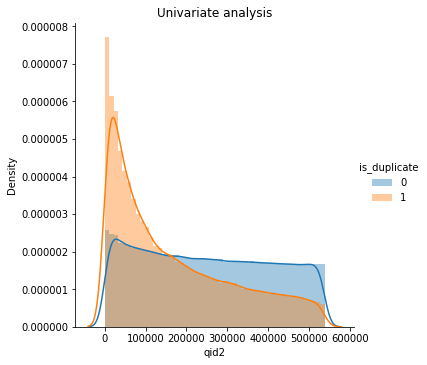

In [7]:
# EDA - univariate analysis
sns.FacetGrid(trainData, hue="is_duplicate", size=5).map(sns.distplot, "qid2").add_legend();
plt.title('Univariate analysis')
plt.ylabel("Density")
plt.show();

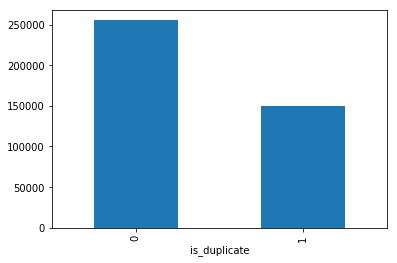

In [8]:
# frequency of is_duplicates
trainData.groupby('is_duplicate')['id'].count().plot.bar()
plt.show()

In [9]:
# question pairs analysis
print('Total number of question pairs for training: {}'.format(len(trainData)))
print()
print('Question pairs are not Similar (is_duplicate = 0): {}%'.format(100 - round(trainData['is_duplicate'].mean()*100, 2)))
print()
print('Question pairs are Similar (is_duplicate = 1): {}%'.format(round(trainData['is_duplicate'].mean()*100, 2)))
qids = pd.Series(trainData['qid1'].tolist() + trainData['qid2'].tolist())
uniqueIds = len(np.unique(qids))
repeatedCount = np.sum(qids.value_counts() > 1)
print()
print ('Total number of unique Questions are: {}'.format(uniqueIds))
print()
print ('Number of unique questions that appear more than one time: {} ({}%)'.format(repeatedCount,repeatedCount/uniqueIds*100))
print()
print ('Max number of times a single question is repeated: {}'.format(max(qids.value_counts()))) 


Total number of question pairs for training: 404287

Question pairs are not Similar (is_duplicate = 0): 63.08%

Question pairs are Similar (is_duplicate = 1): 36.92%

Total number of unique Questions are: 537929

Number of unique questions that appear more than one time: 111778 (20.779322178205675%)

Max number of times a single question is repeated: 157


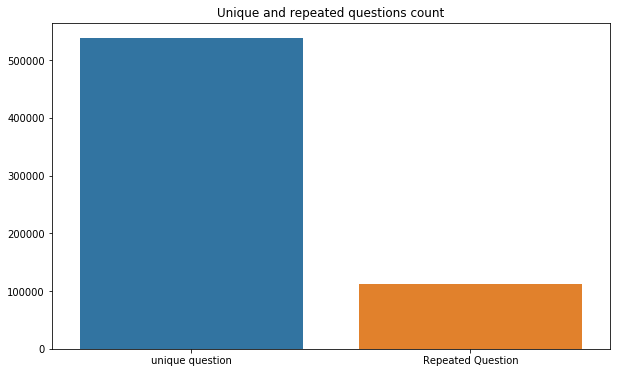

In [10]:
x = ['unique question', 'Repeated Question']
y = [uniqueIds, repeatedCount]
plt.figure(figsize=(10, 6))
plt.title("Unique and repeated questions count")
sns.barplot(x, y)
plt.show()

Word Cloud for Duplicate Question pairs


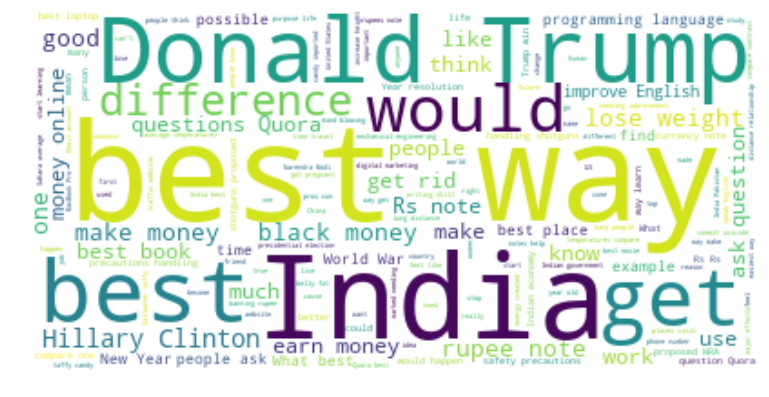

In [11]:
wc = WordCloud(background_color="white",stopwords=stopwords.words('english')).generate(" ".join(trainData[trainData['is_duplicate']==1]['question1']))
print ("Word Cloud for Duplicate Question pairs")
plt.figure(figsize=(13,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for Non-Duplicate Question pairs


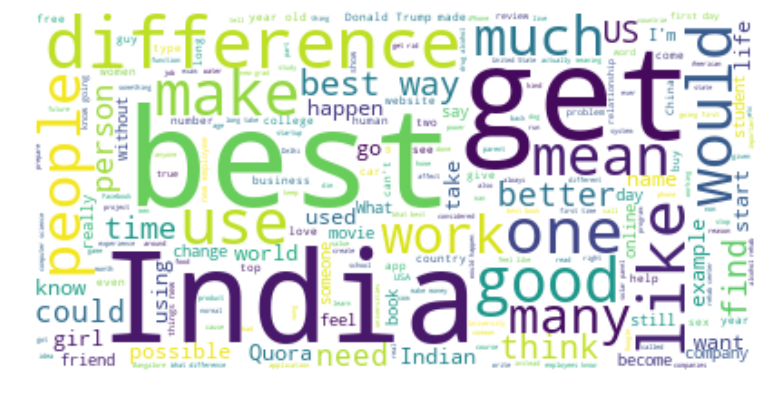

In [12]:
wc = WordCloud(background_color="white",stopwords=stopwords.words('english')).generate(" ".join(trainData[trainData['is_duplicate']==0]['question1']))
print ("Word Cloud for Non-Duplicate Question pairs")
plt.figure(figsize=(13,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [13]:
# Checking for any repeated question pairs
pairDuplicates = trainData[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print("Number of repeated question pairs",pairDuplicates.shape[0] - trainData.shape[0])

Number of repeated question pairs 0


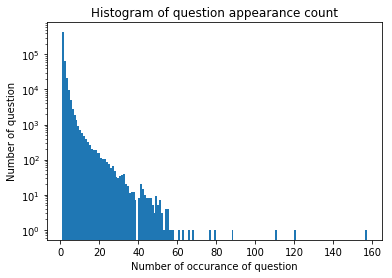

In [14]:
# Number of occurances of each questions
plt.hist(qids.value_counts(),bins=160)
plt.yscale('log', nonposy='clip')
plt.title('Histogram of question appearance count')
plt.xlabel('Number of occurance of question')
plt.ylabel('Number of question')
plt.show()

In [15]:
# preprocess text
SAFE_DIV = 0.0001

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = BeautifulSoup(x,"html.parser") #removing html tags
    x = re.sub("[^a-zA-Z]", " ", x.get_text())  # removing numbers and others except small and capital alphabets
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
        .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
        .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
        .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
        .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
        .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
        .replace("€", " euro ").replace("'ll", " will")
    
    x = x.split() #spiliting sentences into words
    useful = [w for w in x if not w in STOP_WORDS]  #removing stopping words
    
    return " ".join(useful)

In [16]:
trainData["question1"] = trainData["question1"].fillna("").apply(preprocess)
trainData["question2"] = trainData["question2"].fillna("").apply(preprocess)

In [17]:
# displaying after preprocessing
trainData.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,step step guide invest share market india,step step guide invest share market,0
1,1,3,4,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...,0
2,2,5,6,increase speed internet connection using vpn,internet speed increased hacking dns,0
3,3,7,8,mentally lonely solve,find remainder math math divided,0
4,4,9,10,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0


In [18]:
# getting features and targets
feature = trainData[['question1', 'question2']]
target = trainData['is_duplicate']

In [19]:
# splitting for training and testing
X_train, X_test, y_train, y_test = train_test_split(feature,
                                                    target,
                                                    test_size=0.3)

In [20]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283000, 2)
Number of data points in test data : (121287, 2)


In [21]:
# converting text into vectors -> vectorisation
tfidfVectorizerQuestion1 = TfidfVectorizer()

question1Vectorized = tfidfVectorizerQuestion1.fit_transform(X_train['question1'].values.astype('U'))

In [22]:
print("Found {0} features from question1 column".format(len(tfidfVectorizerQuestion1.get_feature_names())))

Found 54311 features from question1 column


In [23]:
tfidfVectorizerQuestion2 = TfidfVectorizer()

question2Vectorized = tfidfVectorizerQuestion2.fit_transform(X_train['question2'].values.astype('U'))

In [24]:
print("Found {0} features from question2 column".format(len(tfidfVectorizerQuestion2.get_feature_names())))

Found 49653 features from question2 column


In [25]:
# combining vectorised input
questions = hstack((question1Vectorized, question2Vectorized))

In [26]:
questions

<283000x103964 sparse matrix of type '<class 'numpy.float64'>'
	with 2953819 stored elements in COOrdinate format>

In [27]:
X_train.drop(['question1','question2'], axis=1, inplace=True)
X_train = hstack((X_train, questions),format="csr",dtype='float64')

In [28]:
X_train.shape

(283000, 103964)

In [29]:
question1Vectorized_test = tfidfVectorizerQuestion1.transform(X_test['question1'].values.astype('U'))
question2Vectorized_test = tfidfVectorizerQuestion2.transform(X_test['question2'].values.astype('U'))
questionsTest = hstack((question1Vectorized_test,question2Vectorized_test))
X_test.drop(['question1','question2'] , axis=1,inplace=True)
X_test = hstack((X_test,questionsTest),format='csr',dtype='float64')
X_test.shape

(121287, 103964)

In [30]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
print("Class 0: ",int(Counter(y_train)[0])/len(y_train),"Class 1: ", int(Counter(y_train)[1])/len(y_train))
print("-"*10, "Distribution of output variable in test data", "-"*10)
print("Class 0: ",int(Counter(y_test)[1])/len(y_test), "Class 1: ",int(Counter(y_test)[1])/len(y_test))

---------- Distribution of output variable in train data ----------
Class 0:  0.6307420494699647 Class 1:  0.36925795053003535
---------- Distribution of output variable in test data ----------
Class 0:  0.3690667590096218 Class 1:  0.3690667590096218


In [31]:
# Machine Learning Modeling

In [32]:
# SGD Classifier
alpha = [10 ** x for x in range(-5, 2)] 

error = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    error.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 0.5217208600810436
For values of alpha =  0.0001 The log loss is: 0.5430286022688022
For values of alpha =  0.001 The log loss is: 0.5754494908813806
For values of alpha =  0.01 The log loss is: 0.5933918876471125
For values of alpha =  0.1 The log loss is: 0.5991494035364882
For values of alpha =  1 The log loss is: 0.6096633923689591
For values of alpha =  10 The log loss is: 0.6116114918153679


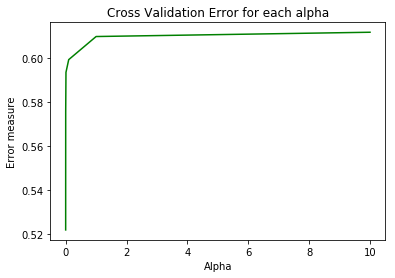

In [33]:
plt.plot(alpha, error,c='g')
plt.grid(False)
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("Error measure")
plt.show()

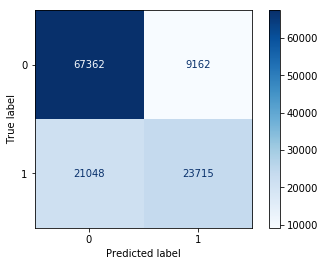

In [34]:
# training using best params
clf = SGDClassifier(alpha=alpha[np.argmin(error)], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)


predicted_y = np.argmax(sig_clf.predict_proba(X_test), axis=1)
plot_confusion_matrix(sig_clf, X_test, y_test,cmap='Blues')
plt.show()

In [35]:
print(classification_report(y_test,predicted_y ))

              precision    recall  f1-score   support

           0       0.76      0.88      0.82     76524
           1       0.72      0.53      0.61     44763

    accuracy                           0.75    121287
   macro avg       0.74      0.71      0.71    121287
weighted avg       0.75      0.75      0.74    121287



In [36]:
sgdAccuracy = accuracy_score(y_test,predicted_y)

In [37]:
# sparse SVM
clf = LinearSVC(penalty="l1",
                loss="squared_hinge",
                dual=False,
                tol=1e-3,
                max_iter=10)
cs = np.logspace(-2.3, -1.3, 10)
colors = ["navy", "cyan", "darkorange"]
lw = 2
param_grid = dict(C=cs)
grid = GridSearchCV(
    clf,
    refit=False,
    param_grid=param_grid,
    cv=ShuffleSplit(train_size=0.7, test_size=0.3, n_splits=50,
                    random_state=1),
)
grid.fit(X_train, y_train)
scores = grid.cv_results_["mean_test_score"]

In [38]:
grid.best_params_

{'C': 0.05011872336272722}

In [39]:
clf = LinearSVC(penalty="l1",
                loss="squared_hinge",
                dual=False,
                tol=1e-3,
                max_iter=10,
                C=grid.best_params_['C'])
clf.fit(X_train, y_train)
ypred = clf.predict(X_test)

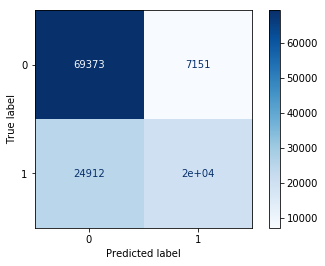

In [40]:
plot_confusion_matrix(clf, X_test, y_test,cmap='Blues')
plt.show()

In [41]:
print(classification_report(y_test,ypred ))

              precision    recall  f1-score   support

           0       0.74      0.91      0.81     76524
           1       0.74      0.44      0.55     44763

    accuracy                           0.74    121287
   macro avg       0.74      0.68      0.68    121287
weighted avg       0.74      0.74      0.72    121287



In [42]:
linearSVM = accuracy_score(y_test,ypred)

In [43]:
X_train.shape

(283000, 103964)

In [44]:
y_train.shape

(283000,)

In [45]:
# logistic regression
def sigmoid(X, theta):
    z = np.dot(theta, X.T)
    return 1 / (1 + np.exp(-(z))) - 0.0000001

def costFunction(X, y, theta):
    yhat = sigmoid(X, theta)
    return -(1 / len(X)) * np.sum(y * np.log(yhat) +
                                  (1 - y) * np.log(1 - yhat))

def gradientDescentFunction(X, y, theta, alpha, epochs):
    losses = [costFunction(X, y, theta)]
    previousTemp = 0
    cnt = 0
    for i in range(epochs):
        h = sigmoid(X, theta)
        for i in range(0, len(X.columns)):
            theta[i] += (alpha / len(X)) * np.sum((h - y) * X.iloc[:, i])
        temp = costFunction(X, y, theta)
        if temp == previousTemp:
            cnt += 1
        else:
            previousTemp = temp
            cnt = 0
        if cnt == epochs * 0.1:
            print("Early stopping!!! Convergence occurred")
            break
        losses.append(temp)
    return losses, theta

def train(X, y, theta, alpha, epochs):
    lossValues, weights = gradientDescentFunction(X, y, theta, alpha, epochs)
    return lossValues, weights

def predict(X, theta):
    pred = sigmoid(X, theta)
    for i in range(len(pred)):
        if pred[i] >= 0.5:
            pred[i] = 1
        else:
            pred[i] = 0
    return pred

In [46]:
theta = [0.0] * X_train[:100].toarray().shape[1]
loss, weights = train(pd.DataFrame(X_train[:100].toarray()), y_train[:100], theta, 0.0000001, 10)

Early stopping!!! Convergence occurred


In [48]:
predicted_y = predict(pd.DataFrame(X_test[:100].toarray()), weights)

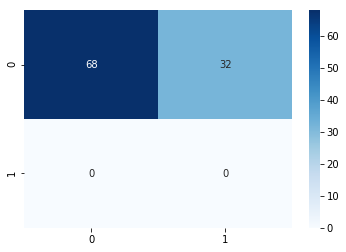

In [51]:
cf = confusion_matrix(predicted_y, y_test[:100])
sns.heatmap(cf, annot=True, cmap='Blues')
plt.show()

In [53]:
print(classification_report(y_test[:100],predicted_y ))

              precision    recall  f1-score   support

           0       0.68      1.00      0.81        68
           1       0.00      0.00      0.00        32

    accuracy                           0.68       100
   macro avg       0.34      0.50      0.40       100
weighted avg       0.46      0.68      0.55       100



In [54]:
logisticAccuracy = accuracy_score(y_test[:100], predicted_y)

In [56]:
x = PrettyTable()
x.title = " Model Comparision "
x.field_names = ['Model', 'Accuracy','Recall', 'Precision']

x.add_row(["SGD Classifier",sgdAccuracy,"0.75","0.75"])
x.add_row(["Linear SVM",linearSVM,"0.74","0.74"])
x.add_row(["Logistic Regression",logisticAccuracy,"0.46","0.68"])
print(x)

+---------------------------------------------------------------+
|                       Model Comparision                       |
+---------------------+--------------------+--------+-----------+
|        Model        |      Accuracy      | Recall | Precision |
+---------------------+--------------------+--------+-----------+
|    SGD Classifier   | 0.7509213683247175 |  0.75  |    0.75   |
|      Linear SVM     | 0.7356435561931617 |  0.74  |    0.74   |
| Logistic Regression |        0.68        |  0.46  |    0.68   |
+---------------------+--------------------+--------+-----------+


In [65]:
question1 = input("Enter question 1:")
question2 = input("Enter question 2:")

Enter question 1:How can I reduce my belly fat through a diet?
Enter question 2:How can I reduce my lower belly fat in one month?


In [66]:
testQuestions = hstack((tfidfVectorizerQuestion1.transform([preprocess(question1)]), tfidfVectorizerQuestion2.transform([preprocess(question2)])))

In [67]:
testQuestions.shape

(1, 103964)

In [68]:
result = sig_clf.predict(testQuestions)
if result[0] == 0:
    print("Not Duplicate")
else:
    print("Duplicate")

Duplicate
